## Face_detection Function

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.neural_network import MLPClassifier

In [42]:

def face_detection(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        new_img = gray[y:y+h, x:x+w]
        new_img = cv2.resize(src=new_img, dsize=(1000, 1000))
        return new_img[:,:]

## Load Data

In [43]:
df = pd.read_csv('data_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   path    26 non-null     object 
 1   label   26 non-null     object 
 2   x       0 non-null      float64
 3   y       0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 960.0+ bytes


In [44]:
h = 1000 # hight
w = 1000 # width
D = h * w
cnt = 1
X = []
img = face_detection(df['path'][0])
X.append(img.reshape(1000000))

for path in df['path'][1:]:
        try:
            img = face_detection(path)
            new_x = img.reshape(D)
            x = []
            x.append(new_x)
            X = np.concatenate((X, x), axis = 0)
            cnt += 1
        except:
            df.drop(cnt, axis=0)
            print("error:", path)

In [45]:
X.shape

(26, 1000000)

## PCA

(1000000, 26)

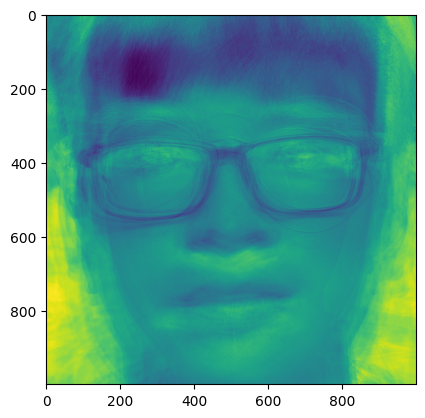

In [46]:
K = cnt
# Doing PCA, note that each row is a datapoint
from sklearn.decomposition import PCA
pca = PCA(n_components = K) # K = 17
pca.fit(X)

# projection matrix
U = pca.components_.T
plt.imshow(U[:,0].reshape(h,w))
U_mean = pca.mean_
U.shape

### X_train - PCA

In [47]:
X_train_pca = pca.transform(X)
X_train_pca[0,:]

array([ 4.38723385e+04, -1.57005702e+04, -9.77973415e+03, -4.20669192e+03,
       -9.47767491e+03,  2.81392190e+03, -4.66514511e+02, -5.05247767e+01,
       -8.39886529e+03,  2.80976865e+03,  3.77098772e+03,  1.82523467e+03,
       -7.68888899e+02, -5.17773565e+02,  3.28967441e+03,  1.18986149e+03,
       -7.17363316e+03,  5.15624886e+03,  3.63376627e+03,  7.85019094e+03,
       -1.08785879e+04, -2.43544230e+02,  1.39760689e+04, -1.51347094e+03,
        5.08891161e+01, -1.54077195e-10])

### K_NN

In [48]:
from sklearn import neighbors, datasets
clf = neighbors.KNeighborsClassifier(n_neighbors = 3, p = 2)
clf.fit(X_train_pca, df['label'])

KNeighborsClassifier(n_neighbors=3)

### Test

In [49]:
img = face_detection('D:\Study\AI\Project\Main\\test_data\\test-4.jpg')
x_test_pca = pca.transform(img.reshape(1,D))
img.shape

(1000, 1000)

In [50]:
y_predic = clf.predict(x_test_pca.reshape(1,K))
y_predic

array(['Tuan'], dtype=object)

## Predict Function

In [51]:
def predict_face(new_face):
    x_test_pca = pca.transform(new_face.reshape(1,D))
    y_predic = clf.predict(x_test_pca.reshape(1,K))
    return y_predic[0]

In [52]:
img = face_detection('D:\Study\AI\Project\Main\\test_data\\test-4.jpg')
y_ =  predict_face(img)
y_

'Tuan'

## Webcam

In [53]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

# Đặt nguồn video thành webcam mặc định mà OpenCV có thể dễ dàng chụp.
video_capture = cv2.VideoCapture(0)
# Ở đây, chúng ta quay video. Hàm read() đọc một khung hình từ nguồn video, trong ví dụ này là webcam. Điều này sẽ trả về:
# 1.Đọc khung video thực tế (một khung trên mỗi lần lặp)
# 2.Một mã trả lại

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Vẽ một hình chữ nhật quanh khuôn mặt
    for (x, y, w, h) in faces:
        font = cv2.FONT_HERSHEY_SIMPLEX
        # Put Text
        new_face = gray[y:y+h, x:x+w]
        new_face = cv2.resize(src=new_face, dsize=(1000, 1000))
        id = predict_face(new_face)
        cv2.putText(frame,id,(x,y-10), font, 1,(239, 50, 239),2,cv2.LINE_AA)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        #cv2.imshow('face', frame[y:y+h, x:x+w])

    # Hiển thị khung kết quả
    cv2.imshow('Predict', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Sau khi thực hiện thành công thì giải phóng ảnh
video_capture.release()
cv2.destroyAllWindows()